<a href="https://colab.research.google.com/github/HarryWang0619/ECE397-QuantumComputing/blob/main/Haochen_Wang_Lab_8_Deutsch_Jozsa_and_Bernstein_Vazirani.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 397 QC

## Introduction to Quantum Computing – Spring 2022

Instructor – Professor Robert Niffenegger (rniffenegger@umass.edu ) Marcus 215B

Labs -  Engineering Lab 307

Time – MWF 12:20-1:10

Teaching Assistant – Ivan Williams ( inwilliams@umass.edu ) 

---

### Textbook
>Quantum Computation and Quantum Information , Authors:	Michael A. Nielsen, Isaac L. Chuang


##Supporting Materials Quantum Computation:

•	Thomas Wong’s Textbook:
https://www.amazon.com/Introduction-Classical-Quantum-Computing-Thomas-dp-B09QP2MYYM/dp/B09QP2MYYM/

http://www.thomaswong.net/introduction-to-classical-and-quantum-computing-1e.pdf

•	IBM’s Qiskit Textbook - https://qiskit.org/textbook-beta 


#How to use this Notebook

1. Create a copy for you to edit and update the filename with your UMass username. 

2. Experiment! This notebook is just a starting point for you to explore. If you have ideas for things to try start by typing out the pseduo code first then see if you can find help to get the syntax and libraries to make it work. 

3. Teamwork. Working in teams will help everyone check their code and debug errors. Please work in groups of up to three people. You may all share code but please maintain your own copy of the notebook to turn in for credit.

4. Hand written paper notebook still required. This colab notebook is a supplement to a paper notebook and the textbooks listed above. To test out ideas, check mathematical relations and linear algebra proofs and to complete exercises you will need a real physical paper notebook to do your work. Please have one and a pen/pencil handy. 
Related: Be careful not to get bogged down in the code if it is not working. Reach out to your team, the TA or me to get assistance. 

5. Programming Resources: 
  *   https://colab.research.google.com/notebooks/basic_features_overview.ipynb
  *   https://www.dataquest.io/blog/jupyter-notebook-tutorial/
  *   https://www.youtube.com/watch?v=inN8seMm7UI 
  *   https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/qubit-dynamics.ipynb
  * FYI: Colab provides hardware acceleration with GPUs and TPUs if you go to 'Runtime>Change Runtime type'


#Qiskit

IBM's Quantum Information Software Kit

In [ ]:
try:
  import qiskit
except ImportError:
  print('Install Qiskit')
  !pip install --quiet qiskit
  !pip install --quiet qiskit[visualization]
  !pip install --quiet git+https://github.com/qiskit-community/qiskit-textbook.git#subdirectory=qiskit-textbook-src

In [ ]:
try:
  import ibm_quantum_widgets
except ImportError:
  !pip install --quiet ibm-quantum-widgets

### Initialize

In [ ]:
%matplotlib inline
from IPython.display import display, Math
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi, sqrt, sin, cos


#Plot setup
from pylab import *
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML


#Qisket imports
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.aer import QasmSimulator


from qiskit.providers.basicaer import BasicAer
from qiskit.providers.aer.noise import *

from qiskit.quantum_info import Statevector
'''
In Jupyter Notebooks we can display this nicely using Latex.
'''
from qiskit.visualization import array_to_latex

#Lab 8 - Deutsch-Jozsa  and Bernstein-Vazirani Algorithms

Overview of Oracle query algorithms.

# Deutsch-Jozsa Algorithm



Problem:

We want to know how a function 'f' will respond to almost all of it's possible inputs without having to input them all into the function to check.


That is, a function f(x) will take a binary bit string 'x' and output a '0' or a '1' and we know that the function is of two possible types. Either: 
1.  Constant - outputing 0 or 1 **regardless** of the input

***or ***

2.  Balanced - outputing '0' 50% of the time and '1' 50% of the time.

Our task is to figure out what type of function it is.
1. Does it always output 1? Does it always output 0? → Then it is constant.
1. Does it output 1 half of the time? (and 0 the other half?) → Then it is balanced.

---

**Classically** we would need to check HALF of the possible inputs (plus one more) as a worst case to know which is which! If all are the same then we know it is a constant function, but if any are different then it must be balanced.

Quantum Mechanically we only need to query **once**!!!

How!?!?!

Let's walk through an example.

References: 
* Lecture by Deutsch - http://www.quiprocone.org/Protected/Lecture_5.htm 
* https://qiskit.org/textbook/ch-algorithms/deutsch-jozsa.html


##Constant Oracle
Start by creating a constant oracle by randomly setting the output qubit to be 0 or 1 (regardless of the input register).

Constant oracle output = 0


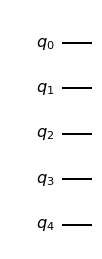

In [ ]:
# Set the size of the input register
n = 4

'''
Constant Oracle
'''
const_oracle = QuantumCircuit(n+1) 

output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)
    print("Constant oracle output = 1")
else:
    print("Constant oracle output = 0")

const_oracle.draw('mpl')

###Constant oracle is boring...
Note nothing really happens. Because the function doesn't care what the input is it just either randomly sets the output to be 0 or 1 using an X-gate...

We could input all of the possible permutations but it just will output the same state... Lame.

##Balanced Oracle

Now create a balanced oracle. 

One way to create a balanced oracle is by performing CNOTs with each input qubit as a control and the output bit as the target. 


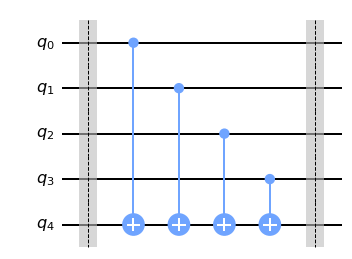

In [ ]:
balanced_oracle = QuantumCircuit(n+1)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

balanced_oracle.draw('mpl')

Now that we have a balanced oracle we can vary the input states that give 0 or 1 by wrapping some of the control nots in X-gates. *This is just to mix it up a little.* The CNOTs are already dictating that the function is balanced, but this varies the outputs a little bit to make it more challenging classically to figure out.

For each qubit in our circuit, we place an X-gate if the corresponding digit in bstr is '1', or do nothing if the digit is '0'.

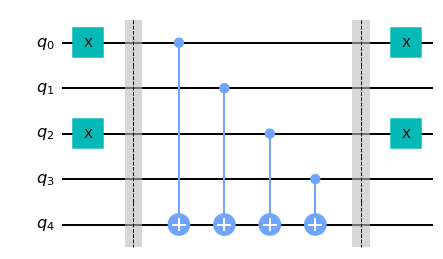

In [ ]:

bstr = "101"

balanced_oracle = QuantumCircuit(n+1)

# Place X-gates
for qubit in range(len(bstr)):
    if bstr[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider to make circuit easier to read.
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(bstr)):
    if bstr[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw('mpl')

Breaking down this circuit:

1. Flip some input states with X-gates to 'mix it up a little'
1. Apply controlled-NOT gates for the balanced oracle, using each input qubit as a control, and the output qubit as a target.
1. Undo the X-gates what we applied to 'mix it up' at the beginning.

(We don't want this balanced oracle to be as boring as the constant oracle do we?)

##Initializing the states

Now that the balanced oracle has been created, we need the Deutsch-Jozsa algorithm to solve it. 

The first steps in the algorithm are to initialize the register:

1. Initialize the input qubits (0-3) in the state |+⟩ (with a H-gate)
1. Initialize the output qubit (4) in the state |−⟩ (with an X-gate then a H-gate)

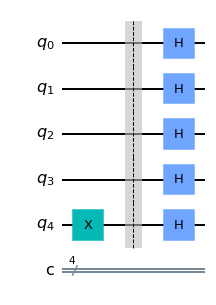

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

'''
Initialize the output qubit in state |->
'''
dj_circuit.x(n)
dj_circuit.barrier() # Barrier just keeps H gates in a single column to look nice
dj_circuit.h(n)


'''
Initialize the input register qubits in state |+>
'''
for qubit in range(n):
    dj_circuit.h(qubit)


dj_circuit.draw('mpl')

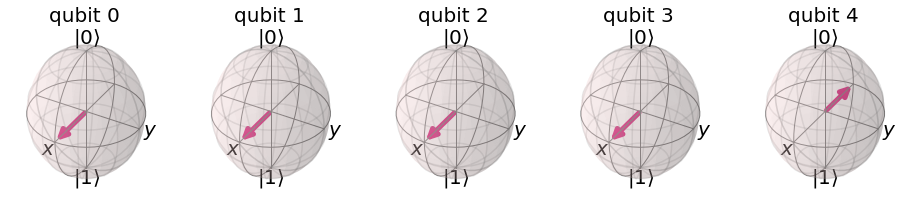

In [ ]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(dj_circuit, backend)).result()
psi  = result.get_statevector(dj_circuit)
# Draw the circuit
plot_bloch_multivector(psi)

Now apply the balanced_oracle function from earlier to apply the oracle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  del sys.path[0]


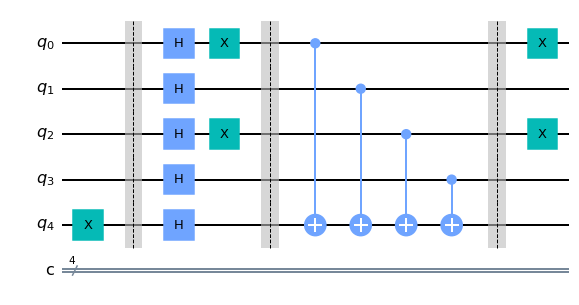

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Add oracle
dj_circuit += balanced_oracle
dj_circuit.draw('mpl')

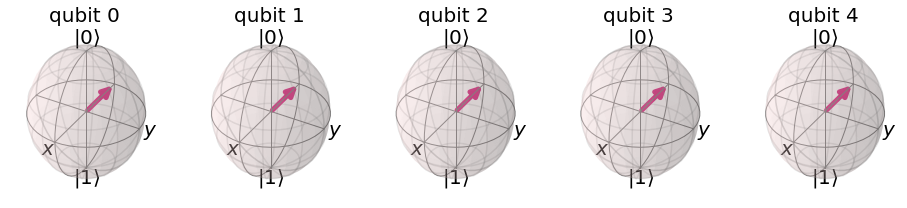

In [ ]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(dj_circuit, backend)).result()
psi  = result.get_statevector(dj_circuit)
# Draw the circuit
plot_bloch_multivector(psi)

## Phase Kickback

The output from the balanced oracle shows that each qubit in the input register has been flipped from |+⟩ to |-⟩ ! 

**This is due to "phase kickback".**

We typically think of CNOTs flipping the target bit only. However, when we have the input and output qubits in superpositions, the INPUT can get a phase flip depending on the output state. This 'reverse' operation is what allows us to query oracle in one step. 

Finally, we perform H-gates on the n-input qubits to bring it back from the X basis (with information in phase) to the Z basis (information in the state, which we can measure).

And, last, measure the input register qubits:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  del sys.path[0]


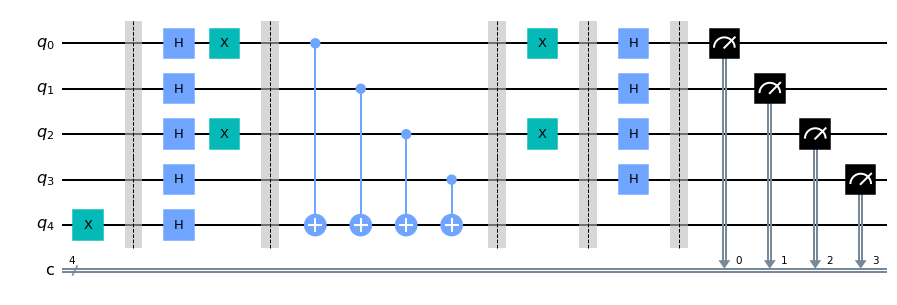

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Add oracle
dj_circuit += balanced_oracle

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

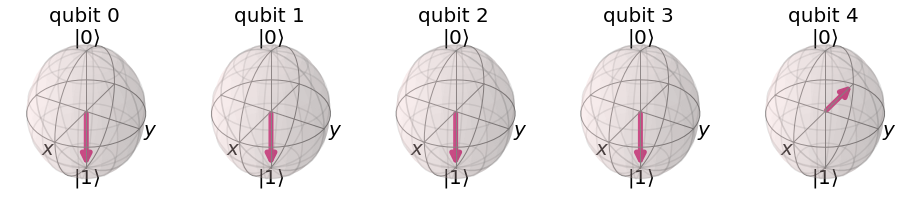

In [ ]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(dj_circuit, backend)).result()
psi  = result.get_statevector(dj_circuit)
# Draw the circuit
plot_bloch_multivector(psi)

All of the input bits have been flipped from initially being in |0⟩ to |1⟩!

---

Let us see what happens with the constant oracle

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  del sys.path[0]


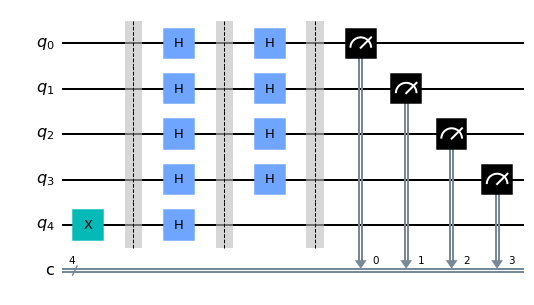

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Add oracle
dj_circuit += const_oracle

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

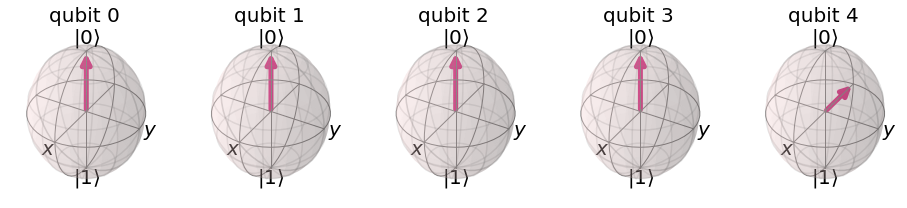

In [ ]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(dj_circuit, backend)).result()
psi  = result.get_statevector(dj_circuit)
# Draw the circuit
plot_bloch_multivector(psi)

## No Phase kickback

A constant oracle doesn't have any phase kickback to the input register. So none of the input qubits are flipped. This means that it must be a constant that is independent of the inputs.


#Phase Kickback derivation

Recall first how we created an entangled state by applying a CNOT to a superposition state.

> Reference: https://qiskit.org/textbook/ch-gates/phase-kickback.html

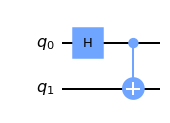

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl')

<IPython.core.display.Latex object>

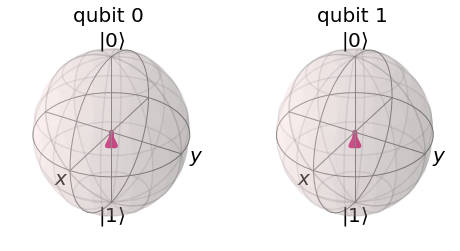

In [ ]:
qc.save_statevector()
qobj = assemble(qc)
svsim = Aer.get_backend('aer_simulator')
final_state = svsim.run(qobj).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

Having the control qubit 0 in a superposition caused the CNOT gate to create the Bell State:

$Ψ = \frac{1}{\sqrt{2}}(|00⟩ + |11⟩)$

If it is in 0 it doesn't flip qubit 1 but if it is in 1 it flips qubit 1. 

This entangled state can not be decomposed/factored into single qubit states.

----

Now, let us also put the output state into a superposition before applying the CNOT gate and see what happens

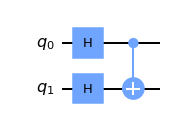

<IPython.core.display.Latex object>

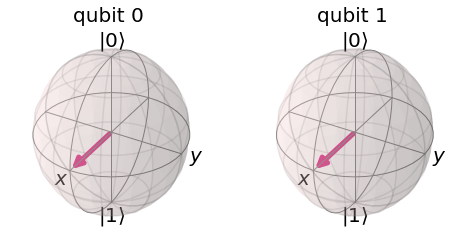

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.cx(0,1)
display(qc.draw('mpl'))

qc.save_statevector()
qobj = assemble(qc)
svsim = Aer.get_backend('aer_simulator')
final_state = svsim.run(qobj).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))

plot_bloch_multivector(final_state)

Now it seems like the CNOT gate doesn't have any effect!
We have the same state after the CNOT as we did before the CNOT. 
Both qubits are in the superposition state |+⟩.

What if we flip the output qubit first so that it is in the |-⟩ state instead?

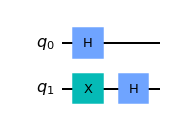

<IPython.core.display.Latex object>

Basis = |00>, |01>, |10> , |11> 


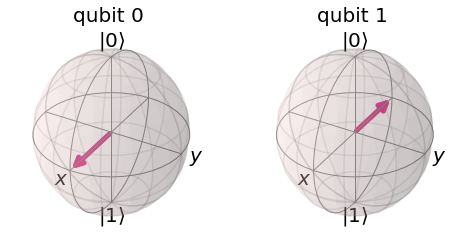

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.h(1)
# qc.cx(0,1)
display(qc.draw('mpl'))

qc.save_statevector()
qobj = assemble(qc)
svsim = Aer.get_backend('aer_simulator')
final_state = svsim.run(qobj).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
print("Basis = |00>, |01>, |10> , |11> ")
plot_bloch_multivector(final_state)

This creates the state:

 $|q_1 q_0⟩ = |-+⟩ = $
 
 $= \frac{1}{\sqrt{2}} [|0⟩-|1⟩] ⊗  \frac{1}{\sqrt{2}} [|0⟩+|1⟩] $
 
 $= \frac{1}{2}[|00⟩ + |01⟩ - |10⟩ - |11⟩]$


> NOTE: the odd 'backwards' notation that qubit 1 is the first qubit and qubit 0 is the last qubit.

----

Now we add the CNOT again to this state:

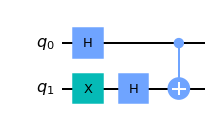

<IPython.core.display.Latex object>

Basis = |00>, |01>, |10> , |11> 


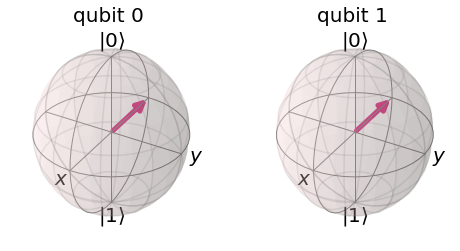

In [ ]:
qc = QuantumCircuit(2)
qc.h(0)
qc.x(1)
qc.h(1)
qc.cx(0,1)
display(qc.draw('mpl'))

qc.save_statevector()
qobj = assemble(qc)
svsim = Aer.get_backend('aer_simulator')
final_state = svsim.run(qobj).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
print("Basis = |00>, |01>, |10> , |11> ")

plot_bloch_multivector(final_state)

The CNOT acting on the state ($q_0$=control, $q_1$=target):

$ |q_1 q_0⟩ = |-+⟩ = \frac{1}{2}[|00⟩ + |01⟩ - |10⟩ - |11⟩]$

* CNOT Flips the $q_1$ in the state $|q_1 q_0⟩ =|01⟩$ to $|q_1 q_0⟩ =|11⟩$ 

* and conversely also flips the $q_1$ in $|q_1 q_0⟩ =|11⟩$ state to $|q_1 q_0⟩ =|01⟩$

> Again note the odd 'backwards' notation that the control qubit 0 is the last qubit and the target qubit 1 is the first qubit.

This SWAPs their amplitudes and since we had prepared them with different signs they flip **sign**.

Together:

$CNOT|-+⟩ = |q_1 q_0⟩ = $

$ = CNOT \frac{1}{2}[|00⟩ + |01⟩ - |10⟩ - |11⟩]  $

$=\frac{1}{2}[|00⟩ - |01⟩ - |10⟩ + |11⟩]$

$= \frac{1}{\sqrt{2}} [|0⟩-|1⟩] ⊗  \frac{1}{\sqrt{2}} [|0⟩-|1⟩] $

$= |--⟩$

So we get the somewhat surprising result that:

$CNOT|-+⟩ = |--⟩$

We use this effect of phase kickback for these phase oracles by putting the input states into a superposition state of |+⟩ and the output state into the superposition state |-⟩ and see if the input states get phase kickbacks during the application of the oracle.

One way to interpret why these algorithms work is to see that they flip the input and output of the classical function. Because the output is modulo 2 it can only give information one bit at a time. By using phase kickback to make the input an output of the circuit we get a bit of information from every input bit (which is all of it). Indeed we don't even need to measure the 'output' bit!!!

#Simulate the DJ algorithm
What is the output when we have a balanced oracle?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  app.launch_new_instance()


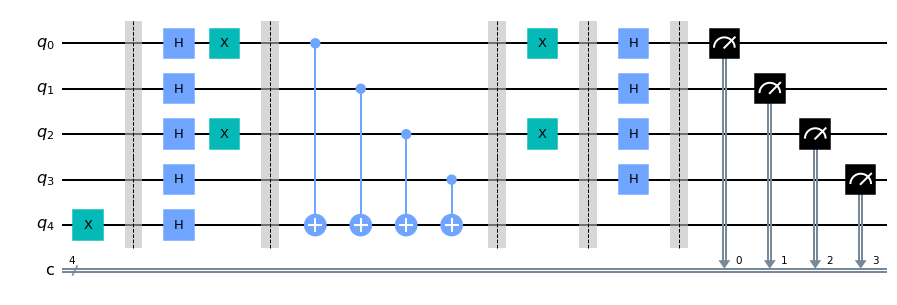

In [ ]:

dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

'''
Add the Balanced Oracle
'''
dj_circuit += balanced_oracle

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')


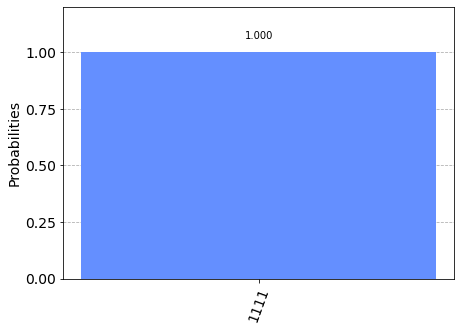

In [ ]:
# Local simulator
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

If the state is not all 0's  |0 0 0 0⟩ that means the function is balanced.

We can see from the results above that we have a 0% chance of measuring 0000 (or any other state than |1111⟩ for that matter). 

This correctly predicts the function is balanced.

# Run on real IBM hardware

In [ ]:
from qiskit import IBMQ

IBMQ.save_account('5a10d5ee58627190cb4edb6096e948bd7011fb62517bce46e1e13f63f33901dae7091e8ab344d243b89a3b0f4b86b217ebfce59b0f5b9185edcbc58c356789ac', overwrite=True)


In [ ]:
# Load our saved IBMQ accounts and list available backends
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')

# List IBM backends available
provider.backends()

ibmqfactory.load_account:WARNING:2022-04-22 05:06:12,611: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [ ]:
# Get the least busy backend device with greater than or equal to (n+1) qubits
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job is queued (28)    

KeyboardInterrupt: ignored

In [ ]:
from qiskit.providers.jobstatus import JobStatus
for job in backend.jobs():
  print(job.job_id(),job.status())
  if job.status() is JobStatus.QUEUED:
    job.cancel()

62623ae1633df2629243edb8 JobStatus.CANCELLED
626238823ba19907ec5665e7 JobStatus.CANCELLED
626236ad4dc879608aee1895 JobStatus.CANCELLED
626236604dc8790ee8ee1894 JobStatus.CANCELLED
6262339ba28f43daf1a0155f JobStatus.CANCELLED
626229006553dc07a79e7240 JobStatus.CANCELLED
626223e19062a6de8acad075 JobStatus.CANCELLED
6256fe77f5707f215aa3a4e2 JobStatus.DONE
62472ddd94be343b54f10f6f JobStatus.CANCELLED


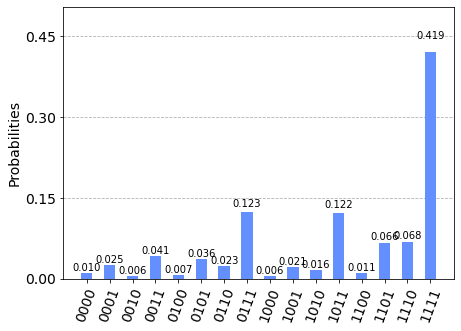

In [ ]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

We get a small chance that the state is |0000⟩ but only about 1%. This is due to errors during the circuit. Repeating the circuit many times we see we get other results ~98% of the time indicating the oracle is balanced.

#Run the Constant Oracle on real hardware

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  app.launch_new_instance()


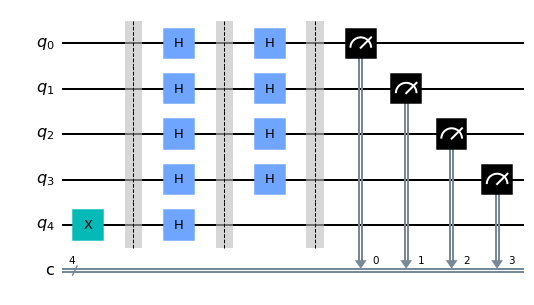

In [ ]:

dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

'''
Add the Constant Oracle
'''
dj_circuit += const_oracle

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')


In [ ]:
# Get the least busy backend device with greater than or equal to (n+1) qubits
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue.
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

IBMQBackendJobLimitError: ignored

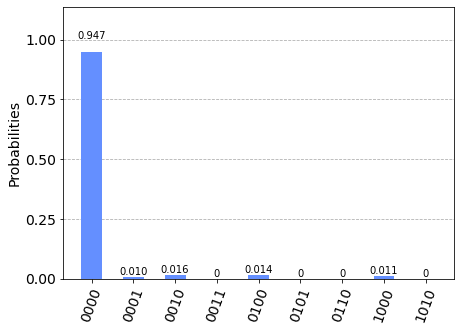

In [ ]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

0000! Success! It is constant oracle with no phase kick back to any of the inputs. 

# Bernstein-Vazirani Algorithm

(aka, Secret Dot Product String)

Deutsch’s algorithm and the Deutsch-Jozsa algorithm both followed the same steps:
1. Apply Hadamard gates
1. Query the Oracle
1. Apply Hadamard gates again
1. Measure

Since this worked so well, are there any other problems that can be solved
by this procedure? The answer is yes. There is another problem that a quantum computer can solve using this procedure.


It is finding a **secret n-bit string** by querying an oracle which takes the dot product of the string with the input.


>That is, we again have a function 'f' that outputs 0 or 1 and can accept a long bit string 'x' as input. But now the promise is that f(x) = s·x, where 's' is an unknown string. 

##How do we figure out what the secret string 's' is?

Classically, we would have to query the function with permutations of a 1 on each input.

\begin{align}
f(0001) = s_3 (0)+s_2 (0)+s_1 (0)+s_0 (1) = s_0 \\
f(0010) = s_3 (0)+s_2 (0)+s_1 (1)+s_0 (0) = s_1 \\
f(0100) = s_3 (0)+s_2 (1)+s_1 (0)+s_0 (0) = s_2 \\
f(1000) = s_3 (1)+s_2 (0)+s_1 (0)+s_0 (0) = s_3 
\end{align}

Requiring n queries.

Quantum mechanically we only need one.

Let's try it.


Reference: 

* [Bernstein-Varizani Algorithm, Qiskit](https://qiskit.org/textbook/ch-algorithms/bernstein-vazirani.html)
* Thomas Wong's book - 7.4 'Secret Dot Product String' 

## Create the 'Secret' bit string 's'
Set the number qubits needed to represent s



In [ ]:
s = '1011'

#number of qubits required to encode s
n = len(s) 
print(n)

# NOTE: If n + 1 = 5 we can run on IBM hardware for free (more than 5 qubits isn't free)

4


Apply Hadamard gates to the qubits, apply an additional Z-gate to the auxiliary qubit

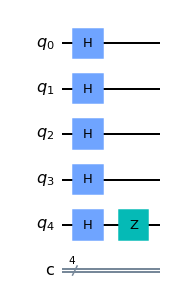

In [ ]:
# n qubits to encode 's' , plus one auxillary qubit
bv_circuit = QuantumCircuit(n+1, n)


# Initialize the auxiliary qubit to state |->
bv_circuit.h(n)
bv_circuit.z(n)

# bv_circuit.barrier()

# Apply Hadamard gates to the input register before querying the oracle
for i in range(n):
    bv_circuit.h(i)

bv_circuit.draw('mpl')

Note: we can prepare the |-⟩ state of the 'output' qubit_4 multiple ways. 

Here we create the |+⟩ state first with a Hadamard, then apply a Z-gate, rotating the phase to the |-⟩ state. 

Next query the inner-product oracle:

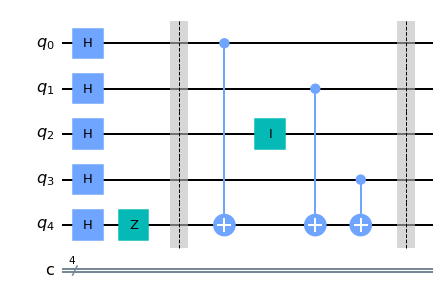

In [ ]:
bv_circuit.barrier()

'''
Oracle for secret 's' string
'''
s_rev = s[::-1] # reverse s to fit qiskit's qubit ordering

for q in range(n):
    if s_rev[q] == '0':
        #If zero just pass the qubit through
        bv_circuit.i(q)
    else:
        #If 1 then 
        bv_circuit.cx(q, n)
        
bv_circuit.barrier()

bv_circuit.draw('mpl')

Apply Hadamard gates after querying 

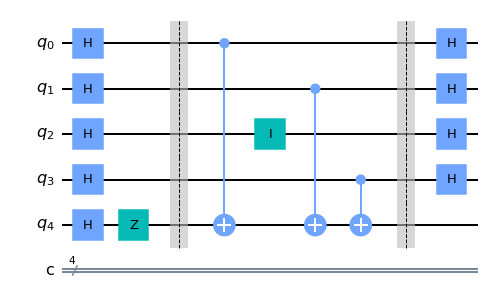

In [ ]:
#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

bv_circuit.draw('mpl')

We complete the circuit by measuring the outputs and storing them onto classical bits:

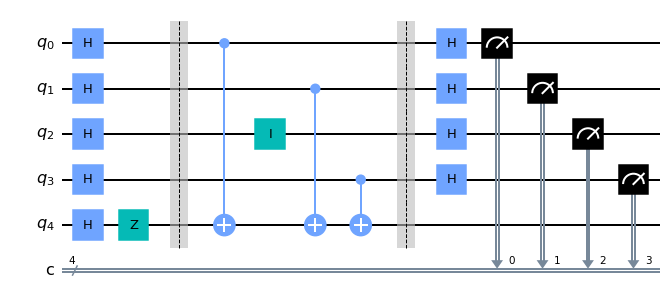

In [ ]:
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw('mpl')

Simulate the quantum circuit:

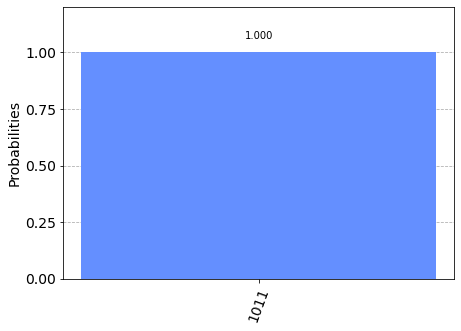

In [ ]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(bv_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
#Get the most likely measured result from the counts
counts = results.get_counts(bv_circuit)
answer = counts.most_frequent()

print( 'Most frequent measured bit string = ' , answer)

#What was the desired solution again?
print( 'Secret s string  = ' , s)


Most frequent measured bit string =  1011
Secret s string  =  1011


## Run on real IBM Hardware

In [ ]:
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

transpiled_bv_circuit = transpile(bv_circuit, backend, optimization_level=3)
job = backend.run(transpiled_bv_circuit)
job_monitor(job, interval=2)

Job Status: job is queued (12)    

In [ ]:
# Get the results of the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)

Not bad! Most of the shots give the correct secret string.

Further reading:

A related algorithm is Simon's Algorithm (https://qiskit.org/textbook/ch-algorithms/simon.html) 

# Exercises

  1. Try breaking the Balanced Oracle by removing and/or adding gates. What do you get?

  1. Setup a Phase kick back circuit and verify the states of both qubits (and the statevector) at each step after each gate. 

  1. Show how phase kick back allows the 'flip' of the control qubit and the target qubit of a CNOT gate such that if a Transmon circuit only has one way coupling between neighboring qubits, the CNOT can STILL operate in both directions.

  1. Test how well the Bernstein-Vazirani algorithm scales classically by running it with different size registers up to 12 qubits and measuring how long it takes to simulate.

  1. Pick an algorithm for your groups final project. Why did you choose this algorithm?

  1. Pick one alternative algorithm for your groups final project in the event that another group also picked your top choice.


### Exercise 1

Try breaking the Balanced Oracle by removing and/or adding gates. What do you get?

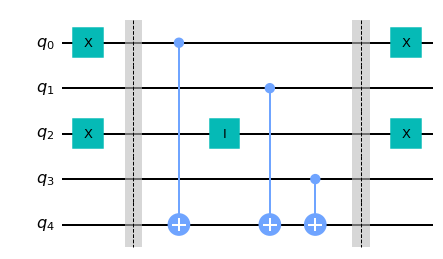

In [ ]:
'''
Exercise 1
'''
n=4
bstr = "101"

balanced_oracle = QuantumCircuit(n+1)

# Place X-gates
for qubit in range(len(bstr)):
    if bstr[qubit] == '1':
        balanced_oracle.x(qubit)

# Use barrier as divider to make circuit easier to read.
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.i(qubit) if qubit==2 else balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(bstr)):
    if bstr[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw('mpl')

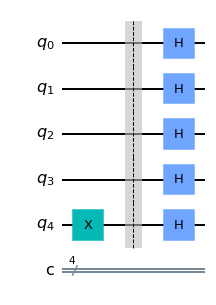

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

dj_circuit.x(n)
dj_circuit.barrier() # Barrier just keeps H gates in a single column to look nice
dj_circuit.h(n)

for qubit in range(n):
    dj_circuit.h(qubit)

dj_circuit.draw('mpl')

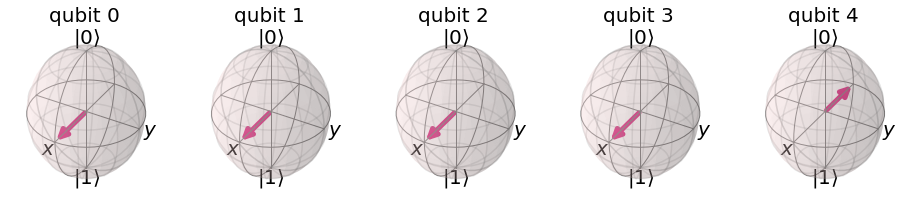

In [ ]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(dj_circuit, backend)).result()
psi  = result.get_statevector(dj_circuit)
# Draw the circuit
plot_bloch_multivector(psi)

NOTHING CHANGED YET

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  del sys.path[0]


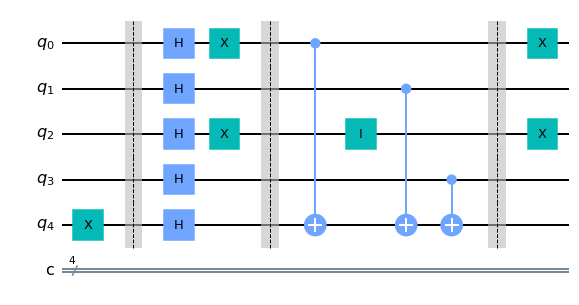

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Add oracle
dj_circuit += balanced_oracle
dj_circuit.draw('mpl')

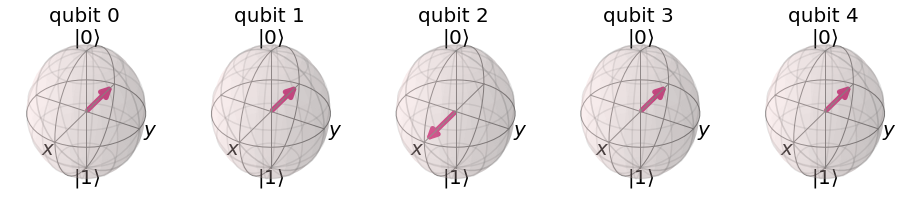

In [ ]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(dj_circuit, backend)).result()
psi  = result.get_statevector(dj_circuit)
# Draw the circuit
plot_bloch_multivector(psi)

STARTING TO GET WEIRD..

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  del sys.path[0]


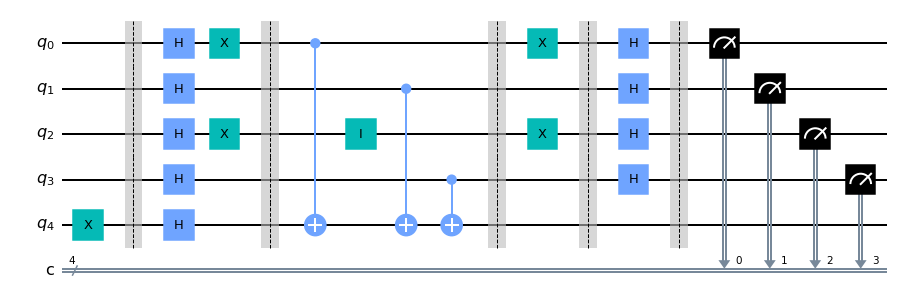

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.barrier()
dj_circuit.h(n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Add oracle
dj_circuit += balanced_oracle

dj_circuit.barrier()

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw('mpl')

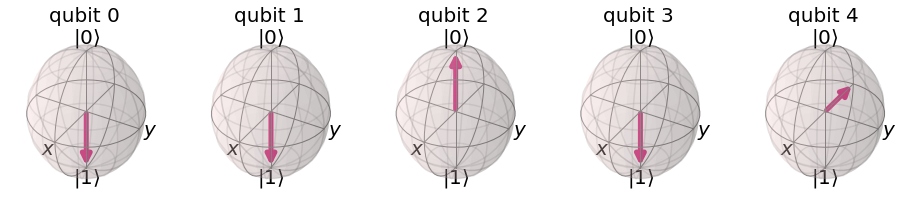

In [ ]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(dj_circuit, backend)).result()
psi  = result.get_statevector(dj_circuit)
# Draw the circuit
plot_bloch_multivector(psi)

##### E1 ANSWER:

This didn't showed us the result we want from the balanced oracle. with delete one CNOT gate, the oracle becomes unbalanced.

### Exercise 2

Setup a Phase kick back circuit and verify the states of both qubits (and the statevector) at each step after each gate.

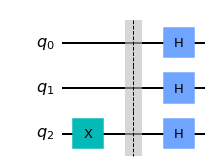

In [ ]:
'''
Exercise 2
'''
from qiskit import QuantumCircuit, Aer, assemble
from math import pi
import numpy as np
from qiskit.visualization import plot_bloch_multivector, plot_histogram, array_to_latex

qc = QuantumCircuit(3)
qc.x(2)
qc.barrier()
qc.h(0)
qc.h(1)
qc.h(2)
qc.draw('mpl')

<IPython.core.display.Latex object>

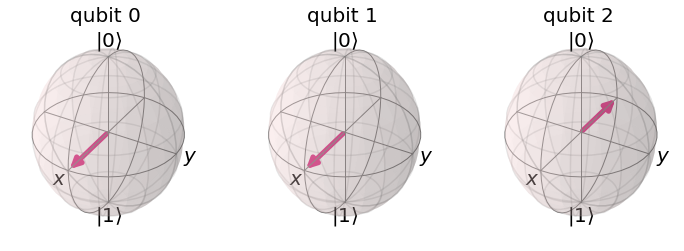

In [ ]:
qc1 = qc.copy()
qc1.save_statevector()
final_state = svsim.run(qc1).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

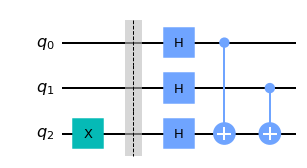

<IPython.core.display.Latex object>

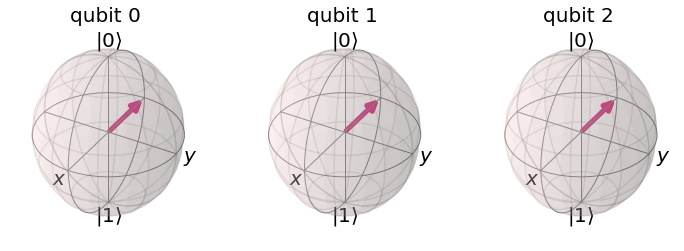

In [ ]:
qc.cx(0,2)
qc.cx(1,2)
display(qc.draw('mpl'))

qc.save_statevector()
qobj = assemble(qc)
svsim = Aer.get_backend('aer_simulator')
final_state = svsim.run(qobj).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

##### E2 ANSWER: 

So, in this three qubit system, controlled qubits' phase got flipped. 

### Exercise 3

Show how phase kick back allows the 'flip' of the control qubit and the target qubit of a CNOT gate such that if a Transmon circuit only has one way coupling between neighboring qubits, the CNOT can STILL operate in both directions.

##### E3 ANSWER:

STAGE 1: 

In the beginning, i have two qubit, the direction only let qubit0 to control qubit1.

q0 is +z,
q1 is -z.

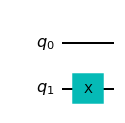

In [ ]:
'''
Exercise 3
'''
qc = QuantumCircuit(2)
qc.x(1)
display(qc.draw('mpl'))

<IPython.core.display.Latex object>

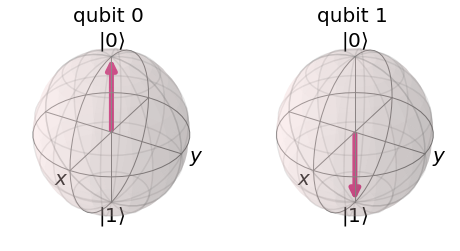

In [ ]:
qc.save_statevector()
final_state = svsim.run(qc).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

STAGE 2: 

If we want to let stage 2 to control q1, we would like to use the phase kickback.

Apply H to both. Make them to +x (and -x) superposition state.

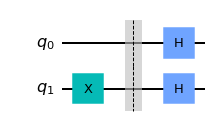

In [ ]:
qc = QuantumCircuit(2)
qc.x(1)
qc.barrier()
qc.h(0)
qc.h(1)
display(qc.draw('mpl'))

<IPython.core.display.Latex object>

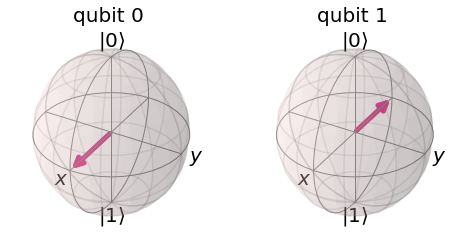

In [ ]:
qc.save_statevector()
final_state = svsim.run(qc).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

STAGE 3: 

Now, use cnot gate to let q0 be control and q2 be target

They are now both -x because of phase kickback

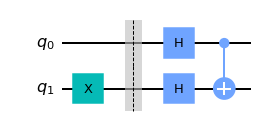

In [ ]:
qc = QuantumCircuit(2)
qc.x(1)
qc.barrier()
qc.h(0)
qc.h(1)
qc.cx(0,1)
display(qc.draw('mpl'))

<IPython.core.display.Latex object>

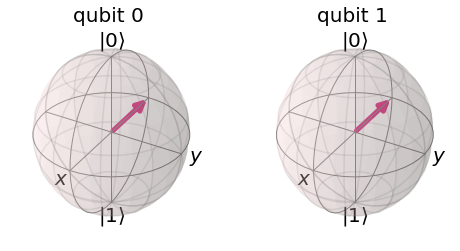

In [ ]:
qc.save_statevector()
final_state = svsim.run(qc).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

STAGE 4: 

Apply H both to change it back to z basis

We have two -z

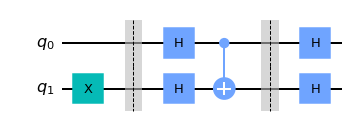

In [ ]:
qc = QuantumCircuit(2)
qc.x(1)
qc.barrier()
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.barrier()
qc.h(0)
qc.h(1)
display(qc.draw('mpl'))

<IPython.core.display.Latex object>

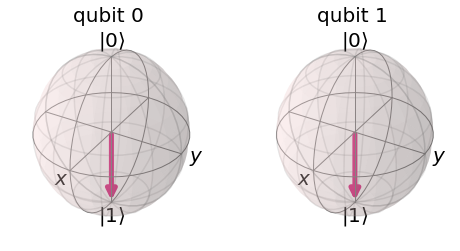

In [ ]:
qc.save_statevector()
final_state = svsim.run(qc).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

We successfully let q1 to 'control' q2. here. We can also try with the three qubit one in Exercise 2, or even four qubits.


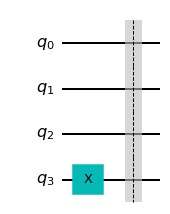

In [ ]:
qc = QuantumCircuit(4)
qc.x(3)
qc.barrier()
# qc.h(0)
# qc.h(1)
# qc.h(2)
# qc.h(3)
qc.draw('mpl')

<IPython.core.display.Latex object>

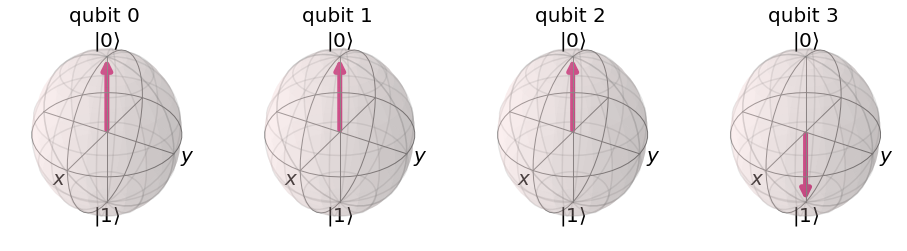

In [ ]:
qc.save_statevector()
final_state = svsim.run(qc).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

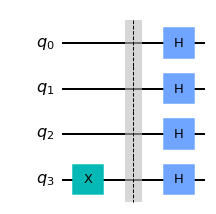

In [ ]:
qc = QuantumCircuit(4)
qc.x(3)
qc.barrier()
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.draw('mpl')

<IPython.core.display.Latex object>

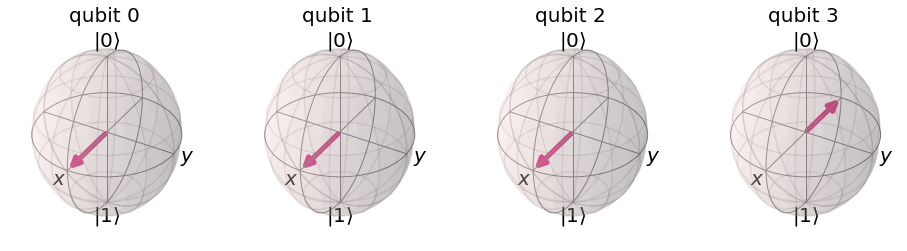

In [ ]:
qc.save_statevector()
final_state = svsim.run(qc).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

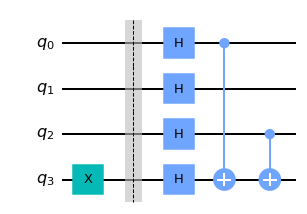

In [ ]:
qc = QuantumCircuit(4)
qc.x(3)
qc.barrier()
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.cx(0,3)
qc.cx(2,3)
qc.draw('mpl')

<IPython.core.display.Latex object>

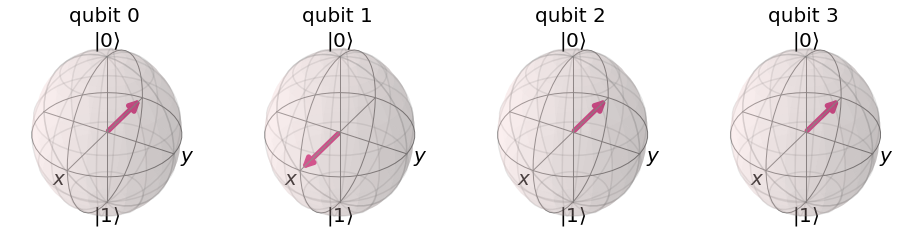

In [ ]:
qc.save_statevector()
final_state = svsim.run(qc).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

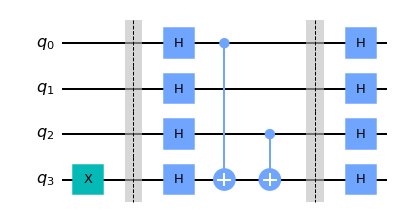

In [ ]:
qc = QuantumCircuit(4)
qc.x(3)
qc.barrier()
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.cx(0,3)
qc.cx(2,3)
qc.barrier()
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.draw('mpl')

<IPython.core.display.Latex object>

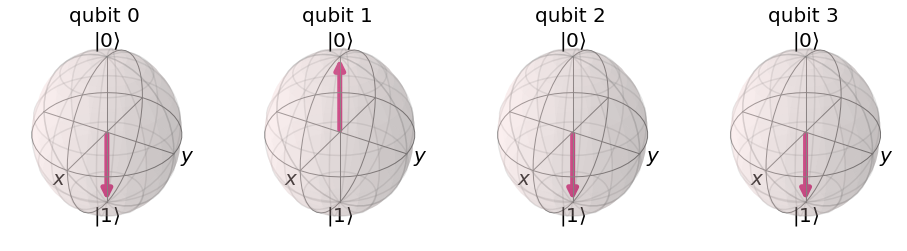

In [ ]:
qc.save_statevector()
final_state = svsim.run(qc).result().get_statevector()
display(array_to_latex(final_state, prefix="\\text{Statevector} = "))
plot_bloch_multivector(final_state)

The qubit with CNOT trying to control q3 instead got controlled by q3. 

### Exercise 4

Test how well the Bernstein-Vazirani algorithm scales classically by running it with different size registers up to 12 qubits and measuring how long it takes to simulate.

In [ ]:
'''
Exercise 4
'''
#random generate s_list:
import random
import time

numberofqubits = 12
slist = []
while len(slist) < numberofqubits-1:
  item = ''
  for i in range(len(slist)+1):
    item+=str(random.randint(0, 1))
  slist.append(item)

print(slist)

['1', '11', '001', '1000', '11001', '110011', '1111110', '11000111', '110001101', '0001110101', '00000000110']


In [ ]:
answer_list = []
time_list = []

for s in slist:
  start_time = time.time()

  n = len(s) 
  # print(n)
  # n qubits to encode 's' , plus one auxillary qubit
  bv_circuit = QuantumCircuit(n+1, n)

  # Initialize the auxiliary qubit to state |->
  bv_circuit.h(n)
  bv_circuit.z(n)

  # Apply Hadamard gates to the input register before querying the oracle
  for i in range(n):
      bv_circuit.h(i)

  bv_circuit.barrier()

  s_rev = s[::-1] # reverse s to fit qiskit's qubit ordering
  for q in range(n):
      if s_rev[q] == '0':
          #If zero just pass the qubit through
          bv_circuit.i(q)
      else:
          #If 1 then 
          bv_circuit.cx(q, n)
          
  bv_circuit.barrier()

  for i in range(n):
    bv_circuit.h(i)

  bv_circuit.barrier()

  for i in range(n):
    bv_circuit.measure(i, i)

  # use local simulator
  aer_sim = Aer.get_backend('aer_simulator')
  shots = 1024
  qobj = assemble(bv_circuit)
  results = aer_sim.run(qobj).result()
  answer = results.get_counts()
  answer_list.append(answer)
  time_list.append(time.time() - start_time)



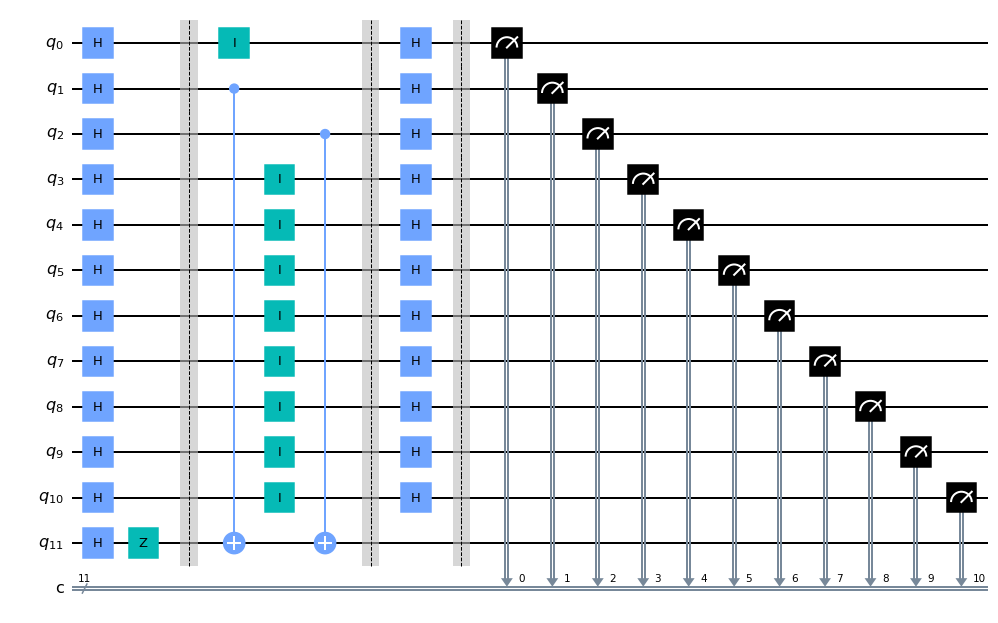

In [ ]:
bv_circuit.draw('mpl')

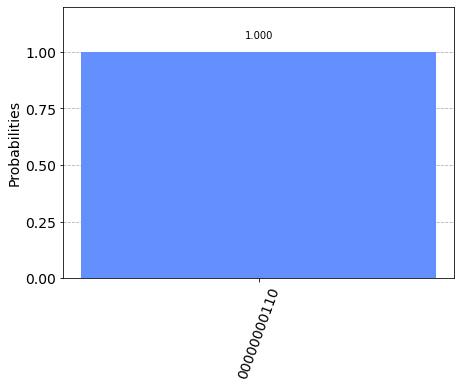

In [ ]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(bv_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [ ]:
for i in range(numberofqubits-1):
  print('Most frequent measured bit string with', i+2, 'qubits = ' , answer_list[i].most_frequent())
  print('Secret s string of',i+1,' qubits = ' , slist[i])
  print('True') if slist[i]==answer_list[i].most_frequent() else print('Not equal')
  print('Time to Execute',i+1,'qubits is',time_list[i], 'seconds')
  print('')

Most frequent measured bit string with 2 qubits =  1
Secret s string of 1  qubits =  1
True
Time to Execute 1 qubits is 0.004300355911254883 seconds

Most frequent measured bit string with 3 qubits =  11
Secret s string of 2  qubits =  11
True
Time to Execute 2 qubits is 0.003945350646972656 seconds

Most frequent measured bit string with 4 qubits =  001
Secret s string of 3  qubits =  001
True
Time to Execute 3 qubits is 0.004214286804199219 seconds

Most frequent measured bit string with 5 qubits =  1000
Secret s string of 4  qubits =  1000
True
Time to Execute 4 qubits is 0.004645109176635742 seconds

Most frequent measured bit string with 6 qubits =  11001
Secret s string of 5  qubits =  11001
True
Time to Execute 5 qubits is 0.005343437194824219 seconds

Most frequent measured bit string with 7 qubits =  110011
Secret s string of 6  qubits =  110011
True
Time to Execute 6 qubits is 0.0063343048095703125 seconds

Most frequent measured bit string with 8 qubits =  1111110
Secret s s

##### E4 ANSWER:

The time usually should scales up linearly. (if there's more zero, then there's more identity matrix so sometimes, say the 12-qubits cost less time than 11-qubits circuit/algorithm.)

### Exercise 5

Pick an algorithm for your groups final project. Why did you choose this algorithm?

##### E5 ANSWER:

Simon's Algorithm 

Details: https://qiskit.org/textbook/ch-algorithms/simon.html

### Exercise 6

Pick one alternative algorithm for your groups final project in the event that another group also picked your top choice.

##### E6 ANSWER:

Quantum Auto-Encoder

Details: https://arxiv.org/pdf/2101.08448.pdf pg.45